## Make imports

In [1]:
import tensorflow as tf

In [2]:
# check if gpu is available
tf.config.experimental.list_physical_devices('GPU')
tf.debugging.set_log_device_placement(True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Simulation functions

In [606]:
def multiBrownian(M, N, dim, T):
    '''
    A multidimensional independent Brownian motion.
    M: Number of samples.
    N: Number of periods.
    dim: Dimension of the brownian motion.
    T: Time interval
    '''
    
    dt = tf.convert_to_tensor(T / (N-1), dtype=tf.float64)
    Z = tf.math.sqrt(dt) * tf.random.normal((M, N, dim), dtype=tf.float64)
    return tf.math.cumsum(Z, axis=1, exclusive=True)

def geometricBM(nb_samples, nb_periods, dim, T, S0, rate, div_yield, sigma, corr):
    '''
    This function will simulate a geometric BM
    
    S0: Initial value. shape = (dim)
    rate: Risk free interest rate (scalar).
    div_yield: Dividends yields. shape = (dim)
    sigma: Volatilities. shape = (dim)
    corr: Correlation matrix. shape = (dim, dim) 
    '''
    # convert to tensor
    S0 = tf.convert_to_tensor(S0, dtype=tf.float64)
    div_yield = tf.convert_to_tensor(div_yield, dtype=tf.float64)
    sigma = tf.convert_to_tensor(sigma, dtype=tf.float64)
    corr = tf.convert_to_tensor(corr, dtype=tf.float64)
        
    # time grid
    t = tf.range(0, T + T / nb_periods, T / (nb_periods - 1), dtype=tf.float64) 
    t = tf.reshape(t, [nb_periods, 1])
    
    # drift
    u = rate - div_yield - sigma ** 2 / 2
    u = tf.reshape(u, [1, dim])

    # get brownian motion
    BM = multiBrownian(nb_samples, nb_periods, dim, T)    
    
    if dim > 1:
        # covariance matrix -------------------
        #temp = sigma[None] * sigma[:, None]
        #cov = tf.multiply(temp, corr)
        #A = tf.linalg.cholesky(cov)

        # or
        sigma_ = tf.reshape(sigma, [dim, 1])
        A = tf.linalg.cholesky(corr)
        A = tf.multiply(A, sigma_)
        # -------------------------------------        
        diffusion_term = tf.linalg.matvec(A, BM)  
    else:
        diffusion_term = BM
        
    res = tf.math.exp(u*t + diffusion_term)    
    return S0 * res

## Test simulation

test


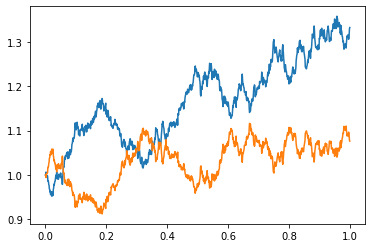

In [603]:
import matplotlib.pyplot as plt

nb_periods = 1000
dim = 2
T = 1
S0 = (1, 1)
corr = [[1.000000001, -1],
        [-1, 1.000000001]]
sigma = (0.2, 0.2)
div_yield = 0
rate = 0.2

x = geometricBM(1, nb_periods, dim, T, S0, rate, 0, sigma, corr)
x = tf.reshape(x, [nb_periods, dim]).numpy()
x = tf.transpose(x)

t = np.linspace(0, 1, N)
plt.plot(t, x[0])
plt.plot(t, x[1])

## Test martingality

In [624]:
nb_periods = 10
nb_samples = 1000000
dim = 2
T = 1
S0 = (1, 2)
corr = [[1, 0],
        [0, 1]]
sigma = (0.2, 0.2)
div_yield = 0
rate = 0.02

x = geometricBM(nb_samples, nb_periods, dim, T, S0, rate, 0, sigma, corr)

In [625]:
tf.reduce_mean(x, axis=0)

<tf.Tensor: shape=(10, 2), dtype=float64, numpy=
array([[1.        , 2.        ],
       [1.00220812, 2.00436924],
       [1.00427976, 2.00861439],
       [1.00659135, 2.01310018],
       [1.00881098, 2.01758773],
       [1.0110464 , 2.0221234 ],
       [1.01327573, 2.02689638],
       [1.01546998, 2.03145406],
       [1.0178335 , 2.03604567],
       [1.01999709, 2.04058714]])>